In [ ]:
import os
os.chdir("/content/drive/MyDrive/DREAM")
!ls

 Data  'Dream Olfactory Mixtures Plan.gdoc'   preprocess.ipynb	 train.ipynb   Trials


In [ ]:
!pip install torch-geometric
!pip install info-nce-pytorch

In [ ]:
import json
import h5py
import base64
import tqdm
import torch
import torch_geometric as tg
import numpy as np

def decode_smiles(encoded):
    return base64.urlsafe_b64decode(encoded.encode()).decode()

missing = 0
full_dataset = dict()
lim = None

with h5py.File('Data/dataset.h5', 'r') as f:
    for i, encoded_pair in enumerate(tqdm.tqdm(f.keys())):
        pair_str = decode_smiles(encoded_pair)
        pair = json.loads(pair_str)

        group = f[encoded_pair]

        positives = group['positives'][:].astype(str).tolist()
        if not positives:
          missing += 1
          continue

        negatives = group['negatives'][:].astype(str).tolist()
        if not negatives:
          missing += 1
          continue

        graph_group = group['graph']
        graph_data = {k: torch.tensor(np.array(v)) for k, v in graph_group.items()}
        graph_data = {k: v.float() if k != "edge_index" else v.long() for k, v in graph_data.items()}

        full_dataset[tuple(pair)] = {"positives":positives, "negatives":negatives, "graph": tg.data.Data(**graph_data)}

        if lim and i > lim:
            break

len(full_dataset), missing

100%|██████████| 166733/166733 [07:18<00:00, 380.02it/s]


(165192, 1541)

In [ ]:
molecule_dictionary = torch.save(dictionary,"dictionary.pt")


In [ ]:
import uuid
TRIAL_ID_LENGTH = 6
trial_id = str(uuid.uuid4())[:TRIAL_ID_LENGTH]
trial_id

'4f5a92'

In [ ]:
import sklearn
import sklearn.model_selection
test_size = 10000
all_keys = list(full_dataset.keys())
train_keys, test_keys = sklearn.model_selection.train_test_split(all_keys,test_size=test_size)
train_dataset = {k:full_dataset[k] for k in train_keys}
test_dataset = {k:full_dataset[k] for k in test_keys}
len(train_dataset), len(test_dataset)

(155192, 10000)

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.data import Dataset
import random
random.seed(42)
# Because we are partitioning the dataset, we may not always be able to find
# a positive for each anchor. If we fail after this many tries, we just skip the
# anchor.
lookup_count = 1000

def get_in_dataset(dataset,pair,key):
    smiles = ""
    i = 0
    # We do random searching because each split may or may not have the requisite
    # pairs to form a anchor/positive/negative triplet.
    while not smiles in dataset:
        smiles = tuple(random.choice(dataset[pair][key]))
        i += 1
        if i > lookup_count:
          raise LookupError(f"Couldn't find a valid item for {key}")
    return smiles

def triplet_graph_generator(dataset,repetitions,num_negatives):
    for _ in tqdm.tqdm(range(repetitions)):
      for anchor in dataset.keys():
          try:
            positive = get_in_dataset(dataset,anchor,"positives")
            negatives = [get_in_dataset(dataset,anchor,"negatives") for _ in range(num_negatives)]
            yield anchor, positive, negatives
          except LookupError as e:
            continue

class TripletGraphDataset(Dataset):
    def __init__(self, dataset, repetitions, num_negatives):
        super(TripletGraphDataset, self).__init__()
         # Converting generator to list for len() support
        self.dataset = dataset
        self.data_list = list(triplet_graph_generator(dataset, repetitions, num_negatives))

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        anchor, positive, negatives = self.data_list[idx]
        # Could change this to a dictionary
        return self.dataset[anchor]["graph"], self.dataset[positive]["graph"], [self.dataset[negative]["graph"] for negative in negatives]


def triplet_collate_fn(batch):
    anchors, positives, negatives = [], [], []
    for anchor, positive, neg_list in batch:
        anchors.append(anchor)
        positives.append(positive)
        negatives.extend(neg_list)
    return Batch.from_data_list(anchors), Batch.from_data_list(positives), Batch.from_data_list(negatives)

# Need to switch the number of negatives over time (this will mean lowering bsz)
# Create an instance of the custom dataset
# This is quite large. Depending on system ram we may need to rethink the way batches are
# loaded in. There is a large amount of duplication.
# Also, our train and test splits should share no common anchors/pairs.
# Its ok if they have common molecules, but they shouldn't have common blends.
# We could just split the dataset and go from there.

train_reps = 150
train = TripletGraphDataset(train_dataset,train_reps,0)

test_reps = 1
test = TripletGraphDataset(test_dataset,test_reps,0)
print(f"Train = {len(train):,}. Test = {len(test):,}.")

100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Train = 23,273,100. Test = 9,735.


In [ ]:
def count_parameters(module):
    return "{:,}".format(sum(p.numel() for p in module.parameters()))

def readout_counts(module):
    results = {"total":count_parameters(module)}
    for n, c in module.named_children():
        results[n] = count_parameters(c)
    return results

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Shamelessly stolen from (and converted to PytorchGeometric)
# https://lifesci.dgl.ai/_modules/dgllife/model/gnn/mpnn.html
class MPNNGNN(nn.Module):
    """MPNN.

    MPNN is introduced in `Neural Message Passing for Quantum Chemistry
    <https://arxiv.org/abs/1704.01212>`__.

    This class performs message passing in MPNN and returns the updated node representations.

    Parameters
    ----------
    node_in_feats : int
        Size for the input node features.
    node_out_feats : int
        Size for the output node representations.
    edge_in_feats : int
        Size for the input edge features.
    edge_hidden_feats : int
        Size for the hidden edge representations.
    num_step_message_passing : int
        Number of message passing steps.
    """
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats, num_step_message_passing, dropout):
        super(MPNNGNN, self).__init__()

        # This should be changed to node wise dropout. But maybe not?
        # See https://arxiv.org/pdf/1411.4280
        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.num_step_message_passing = num_step_message_passing
        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(), # Could add dropout after this.
            nn.Linear(edge_hidden_feats, node_out_feats * node_out_feats),
            nn.Dropout(dropout) # This one is after the largest by far.
        )

        self.gnn_layer = tg.nn.conv.NNConv(
            in_channels=node_out_feats,
            out_channels=node_out_feats,
            nn=edge_network,
            aggr='sum' # If this doesn't work, try `aggregator_type='sum'`

        )

        # If we add a second layer, we could add dropout.
        self.gru = nn.GRU(node_out_feats, node_out_feats,bidirectional=False)
        self.final_dropout = nn.Dropout(dropout)


    def forward(self, graph):
        """Performs message passing and updates node representations.

        Parameters
        ----------
        g : DGLGraph
            DGLGraph for a batch of graphs.
        node_feats : float32 tensor of shape (V, node_in_feats)
            Input node features. V for the number of nodes in the batch of graphs.
        edge_feats : float32 tensor of shape (E, edge_in_feats)
            Input edge features. E for the number of edges in the batch of graphs.

        Returns
        -------
        node_feats : float32 tensor of shape (V, node_out_feats)
            Output node representations.
        """
        node_feats = graph.x
        edge_feats = graph.edge_attr
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            node_feats = F.relu(self.gnn_layer(node_feats, graph.edge_index, edge_feats))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = self.final_dropout(node_feats.squeeze(0))

        return node_feats

# My sense is that we should have multiple convolutions
# Earlier convolutions have more message passing steps (equivalent to kernel size)
# but smaller node/hidden feature sizes (equivalent to channels).
# AlexNet pools between some of the convolutions.
# I'm unsure what would be the equivalent. How would we merge nodes?
# Also, we could maybe augment the graphs with edges (decrease or increase over time)
class Encoder(torch.nn.Module):
    def __init__(self,node_out_feats,edge_hidden_feats,num_step_message_passing, num_sabs, heads, dropout):
        super(Encoder, self).__init__()
        self.conv = MPNNGNN(node_in_feats=9,edge_in_feats=3,node_out_feats=node_out_feats,edge_hidden_feats=edge_hidden_feats,num_step_message_passing=num_step_message_passing,dropout=dropout)
        # https://github.com/davidbuterez/multi-fidelity-gnns-for-drug-discovery-and-quantum-mechanics/blob/3f39d12b66447f62960bf9e4b45070b266328555/schnet_multiple_fidelities/schnet_high_fidelity.py#L159
        # self.readout = tg.nn.aggr.set_transformer.SetTransformerAggregation(node_out_feats,heads=8,num_encoder_blocks=2,num_decoder_blocks=2,dropout=dropout)
        self.readout = tg.nn.aggr.set_transformer.SetTransformerAggregation(node_out_feats,heads=heads,num_encoder_blocks=num_sabs,num_decoder_blocks=num_sabs,dropout=dropout)

    # Cannot get gradient checkpointing to work b/c the SetTransformerAggregation
    # computes dropout internally and doesn't allow checkpointing.
    # We can't combine checkpointing and gradient checkpointing without causing issues.
    # So we could commit to no dropout.
    def forward(self,graph):
        x = self.conv(graph)
        if "batch" in graph:
            return self.readout(x,graph.batch)
        return self.readout(x)

    def count_parameters(self):
        return {"total":count_parameters(self), "conv":count_parameters(self.conv), "readout":count_parameters(self.readout)}

# model = Encoder()
# model(example["graph"])

config = {"node_out_feats":128,"edge_hidden_feats":128,"num_step_message_passing":5, "num_sabs":8,"dropout":0.1, "heads":8}
print(config)
ex_model = Encoder(**config)
# Forward pass through the NNConv layer

example = next(iter(full_dataset.values()))
print(ex_model(example["graph"]).shape)
print(readout_counts(ex_model))
print(readout_counts(ex_model.conv))

{'node_out_feats': 128, 'edge_hidden_feats': 128, 'num_step_message_passing': 5, 'num_sabs': 8, 'dropout': 0.1, 'heads': 8}
torch.Size([1, 128])
{'total': '3,651,072', 'conv': '2,230,912', 'readout': '1,420,160'}
{'total': '2,230,912', 'project_node_feats': '1,280', 'gnn_layer': '2,130,560', 'gru': '99,072', 'final_dropout': '0'}


In [ ]:
import info_nce
import os

def save(path):
  os.makedirs(path,exist_ok=True)
  torch.save({"train_loss":train_losses, "test_loss":test_losses},os.path.join(path,"losses.pt"))
  torch.save(config,os.path.join(path,"config.pt"))
  torch.save(model.state_dict(),os.path.join(path,"model.pt"))

# Create a DataLoader with a custom collate function
bsz = 2**10
print(f"Batch size of {bsz:,}.")
train_loader = DataLoader(train, batch_size=bsz, shuffle=True, collate_fn=triplet_collate_fn)
# Though we could evaluate with a larger bsz, we don't strictly need to.
test_loader = DataLoader(test, batch_size=bsz, shuffle=True, collate_fn=triplet_collate_fn)

model = Encoder(**config)
optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
loss_fn = info_nce.InfoNCE()
model.cuda()

iters_per_tl = 100
save_fraction = .1
iters_per_save = int(len(train_loader)*save_fraction)
print(f"Saving every {iters_per_save} steps.")
test_losses = []
train_losses = []
btls = []

def to_gpu(batch):
  anchors, positives, negatives = batch
  return anchors.cuda(), positives.cuda(), [n.cuda() for n in negatives]

def calc_loss(batch):
    anchors, positives, negatives = to_gpu(batch)
    anchor_embeds = model(anchors)
    positives_embeds = model(positives)
    return loss_fn(anchor_embeds,positives_embeds)

def calc_test_loss():
  tls = []
  with torch.no_grad():
    for tbatch in test_loader:
      with torch.cuda.amp.autocast():
        tls.append(calc_loss(tbatch).cpu().detach().numpy())
  return np.mean(tls)

for i, batch in enumerate(tqdm.tqdm(train_loader,smoothing=0)):
    with torch.cuda.amp.autocast():
      loss = calc_loss(batch)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    btls.append(loss.cpu().detach())

    if (i+1) % iters_per_tl == 0:
      # We calculate the train loss averaged across a number of train steps.
      train_losses.append(np.mean(btls))
      btls = []
      test_losses.append(calc_test_loss())
      print(f"\nStep {i}. Train = {train_losses[-1]:.3f}. Test = {test_losses[-1]:.3f}")

    if (i+1) % int(len(train_loader)*save_fraction) == 0:
      print(f"Checkoint at {i}.")
      save(os.path.join("Trials",trial_id,f"step{i}"))

Batch size of 1,024.
Saving every 2272 steps.


  0%|          | 100/22728 [00:55<3:29:36,  1.80it/s]

\Step 99. Train = 6.882. Test = 6.780


  1%|          | 200/22728 [01:47<3:22:37,  1.85it/s]

\Step 199. Train = 6.779. Test = 6.692


  1%|▏         | 300/22728 [02:38<3:17:47,  1.89it/s]

\Step 299. Train = 6.706. Test = 6.626


  2%|▏         | 400/22728 [03:30<3:15:25,  1.90it/s]

\Step 399. Train = 6.627. Test = 6.561


  2%|▏         | 500/22728 [04:20<3:13:22,  1.92it/s]

\Step 499. Train = 6.563. Test = 6.505


  3%|▎         | 600/22728 [05:11<3:11:21,  1.93it/s]

\Step 599. Train = 6.505. Test = 6.454


  3%|▎         | 700/22728 [06:02<3:09:56,  1.93it/s]

\Step 699. Train = 6.448. Test = 6.408


  4%|▎         | 800/22728 [06:51<3:08:10,  1.94it/s]

\Step 799. Train = 6.405. Test = 6.388


  4%|▍         | 900/22728 [07:41<3:06:21,  1.95it/s]

\Step 899. Train = 6.347. Test = 6.325


  4%|▍         | 1000/22728 [08:30<3:04:57,  1.96it/s]

\Step 999. Train = 6.316. Test = 6.288


  5%|▍         | 1100/22728 [09:21<3:03:51,  1.96it/s]

\Step 1099. Train = 6.276. Test = 6.270


  5%|▌         | 1200/22728 [10:11<3:02:49,  1.96it/s]

\Step 1199. Train = 6.250. Test = 6.236


  6%|▌         | 1300/22728 [11:01<3:01:45,  1.96it/s]

\Step 1299. Train = 6.211. Test = 6.210


  6%|▌         | 1400/22728 [11:51<3:00:40,  1.97it/s]

\Step 1399. Train = 6.200. Test = 6.196


  7%|▋         | 1500/22728 [12:41<2:59:31,  1.97it/s]

\Step 1499. Train = 6.181. Test = 6.181


  7%|▋         | 1600/22728 [13:31<2:58:29,  1.97it/s]

\Step 1599. Train = 6.168. Test = 6.171


  7%|▋         | 1700/22728 [14:21<2:57:32,  1.97it/s]

\Step 1699. Train = 6.144. Test = 6.150


  8%|▊         | 1800/22728 [15:11<2:56:35,  1.98it/s]

\Step 1799. Train = 6.138. Test = 6.153


  8%|▊         | 1900/22728 [16:01<2:55:38,  1.98it/s]

\Step 1899. Train = 6.128. Test = 6.142


  9%|▉         | 2000/22728 [16:51<2:54:44,  1.98it/s]

\Step 1999. Train = 6.106. Test = 6.138


  9%|▉         | 2100/22728 [17:41<2:53:48,  1.98it/s]

\Step 2099. Train = 6.100. Test = 6.129


 10%|▉         | 2200/22728 [18:48<2:55:27,  1.95it/s]

\Step 2199. Train = 6.089. Test = 6.122


 10%|█         | 2300/22728 [19:38<2:54:31,  1.95it/s]

\Step 2299. Train = 6.078. Test = 6.104


 11%|█         | 2400/22728 [20:29<2:53:33,  1.95it/s]

\Step 2399. Train = 6.080. Test = 6.105


 11%|█         | 2500/22728 [21:19<2:52:33,  1.95it/s]

\Step 2499. Train = 6.068. Test = 6.107


 11%|█▏        | 2600/22728 [22:09<2:51:31,  1.96it/s]

\Step 2599. Train = 6.059. Test = 6.094


 12%|█▏        | 2700/22728 [22:59<2:50:31,  1.96it/s]

\Step 2699. Train = 6.058. Test = 6.090


 12%|█▏        | 2800/22728 [23:49<2:49:34,  1.96it/s]

\Step 2799. Train = 6.044. Test = 6.094


 13%|█▎        | 2900/22728 [24:39<2:48:36,  1.96it/s]

\Step 2899. Train = 6.052. Test = 6.081


 13%|█▎        | 3000/22728 [25:29<2:47:38,  1.96it/s]

\Step 2999. Train = 6.040. Test = 6.089


 14%|█▎        | 3100/22728 [26:19<2:46:42,  1.96it/s]

\Step 3099. Train = 6.038. Test = 6.078


 14%|█▍        | 3200/22728 [27:10<2:45:50,  1.96it/s]

\Step 3199. Train = 6.026. Test = 6.075


 15%|█▍        | 3300/22728 [28:00<2:44:53,  1.96it/s]

\Step 3299. Train = 6.024. Test = 6.067


 15%|█▍        | 3400/22728 [28:50<2:43:58,  1.96it/s]

\Step 3399. Train = 6.028. Test = 6.069


 15%|█▌        | 3500/22728 [29:40<2:43:03,  1.97it/s]

\Step 3499. Train = 6.011. Test = 6.061


 16%|█▌        | 3600/22728 [30:30<2:42:08,  1.97it/s]

\Step 3599. Train = 6.010. Test = 6.065


 16%|█▋        | 3700/22728 [31:21<2:41:14,  1.97it/s]

\Step 3699. Train = 6.021. Test = 6.071


 17%|█▋        | 3800/22728 [32:11<2:40:21,  1.97it/s]

\Step 3799. Train = 6.010. Test = 6.058


 17%|█▋        | 3900/22728 [33:01<2:39:28,  1.97it/s]

\Step 3899. Train = 6.018. Test = 6.053


 18%|█▊        | 4000/22728 [33:51<2:38:30,  1.97it/s]

\Step 3999. Train = 6.001. Test = 6.052


 18%|█▊        | 4100/22728 [34:42<2:37:40,  1.97it/s]

\Step 4099. Train = 6.007. Test = 6.047


 18%|█▊        | 4200/22728 [35:31<2:36:44,  1.97it/s]

\Step 4199. Train = 5.996. Test = 6.051


 19%|█▉        | 4300/22728 [36:21<2:35:47,  1.97it/s]

\Step 4299. Train = 6.000. Test = 6.052


 19%|█▉        | 4400/22728 [37:11<2:34:53,  1.97it/s]

\Step 4399. Train = 5.994. Test = 6.044


 20%|█▉        | 4500/22728 [38:01<2:33:59,  1.97it/s]

\Step 4499. Train = 5.987. Test = 6.055


 20%|██        | 4600/22728 [38:50<2:33:03,  1.97it/s]

\Step 4599. Train = 5.980. Test = 6.043


 21%|██        | 4700/22728 [39:40<2:32:12,  1.97it/s]

\Step 4699. Train = 5.985. Test = 6.039


 21%|██        | 4800/22728 [40:31<2:31:21,  1.97it/s]

\Step 4799. Train = 5.987. Test = 6.030


 22%|██▏       | 4900/22728 [41:21<2:30:27,  1.97it/s]

\Step 4899. Train = 5.988. Test = 6.037


 22%|██▏       | 5000/22728 [42:11<2:29:34,  1.98it/s]

\Step 4999. Train = 5.980. Test = 6.047


 22%|██▏       | 5100/22728 [43:00<2:28:39,  1.98it/s]

\Step 5099. Train = 5.987. Test = 6.031


 23%|██▎       | 5200/22728 [43:51<2:27:48,  1.98it/s]

\Step 5199. Train = 5.989. Test = 6.029


 23%|██▎       | 5300/22728 [44:41<2:26:56,  1.98it/s]

\Step 5299. Train = 5.971. Test = 6.032


 24%|██▍       | 5400/22728 [45:31<2:26:04,  1.98it/s]

\Step 5399. Train = 5.980. Test = 6.029


 24%|██▍       | 5500/22728 [46:20<2:25:10,  1.98it/s]

\Step 5499. Train = 5.967. Test = 6.027


 25%|██▍       | 5600/22728 [47:10<2:24:17,  1.98it/s]

\Step 5599. Train = 5.964. Test = 6.038


 25%|██▌       | 5700/22728 [48:00<2:23:26,  1.98it/s]

\Step 5699. Train = 5.968. Test = 6.025


 26%|██▌       | 5800/22728 [48:51<2:22:35,  1.98it/s]

\Step 5799. Train = 5.951. Test = 6.031


 26%|██▌       | 5900/22728 [49:41<2:21:43,  1.98it/s]

\Step 5899. Train = 5.961. Test = 6.022


 26%|██▋       | 6000/22728 [50:31<2:20:51,  1.98it/s]

\Step 5999. Train = 5.969. Test = 6.032


 27%|██▋       | 6100/22728 [51:20<2:19:58,  1.98it/s]

\Step 6099. Train = 5.959. Test = 6.032


 27%|██▋       | 6200/22728 [52:10<2:19:06,  1.98it/s]

\Step 6199. Train = 5.961. Test = 6.020


 28%|██▊       | 6300/22728 [53:00<2:18:14,  1.98it/s]

\Step 6299. Train = 5.967. Test = 6.019


 28%|██▊       | 6400/22728 [53:51<2:17:24,  1.98it/s]

\Step 6399. Train = 5.950. Test = 6.013


 29%|██▊       | 6500/22728 [54:41<2:16:31,  1.98it/s]

\Step 6499. Train = 5.958. Test = 6.022


 29%|██▉       | 6600/22728 [55:32<2:15:42,  1.98it/s]

\Step 6599. Train = 5.951. Test = 6.032


 29%|██▉       | 6700/22728 [56:22<2:14:51,  1.98it/s]

\Step 6699. Train = 5.952. Test = 6.013


 30%|██▉       | 6800/22728 [57:13<2:14:01,  1.98it/s]

\Step 6799. Train = 5.943. Test = 6.017


 30%|███       | 6900/22728 [58:02<2:13:09,  1.98it/s]

\Step 6899. Train = 5.944. Test = 6.026


 31%|███       | 7000/22728 [58:53<2:12:18,  1.98it/s]

\Step 6999. Train = 5.954. Test = 6.007


 31%|███       | 7100/22728 [59:43<2:11:27,  1.98it/s]

\Step 7099. Train = 5.948. Test = 6.011


 32%|███▏      | 7200/22728 [1:00:33<2:10:36,  1.98it/s]

\Step 7199. Train = 5.929. Test = 6.002


 32%|███▏      | 7300/22728 [1:01:23<2:09:45,  1.98it/s]

\Step 7299. Train = 5.948. Test = 6.017


 33%|███▎      | 7400/22728 [1:02:13<2:08:52,  1.98it/s]

\Step 7399. Train = 5.933. Test = 6.005


 33%|███▎      | 7500/22728 [1:03:03<2:08:02,  1.98it/s]

\Step 7499. Train = 5.938. Test = 6.003


 33%|███▎      | 7600/22728 [1:03:53<2:07:10,  1.98it/s]

\Step 7599. Train = 5.938. Test = 6.014


 34%|███▍      | 7700/22728 [1:04:44<2:06:20,  1.98it/s]

\Step 7699. Train = 5.934. Test = 6.006


 34%|███▍      | 7800/22728 [1:05:33<2:05:28,  1.98it/s]

\Step 7799. Train = 5.928. Test = 6.004


 35%|███▍      | 7900/22728 [1:06:24<2:04:38,  1.98it/s]

\Step 7899. Train = 5.935. Test = 6.003


 35%|███▌      | 8000/22728 [1:07:13<2:03:46,  1.98it/s]

\Step 7999. Train = 5.936. Test = 6.004


 36%|███▌      | 8100/22728 [1:08:03<2:02:54,  1.98it/s]

\Step 8099. Train = 5.931. Test = 6.002


 36%|███▌      | 8200/22728 [1:08:53<2:02:03,  1.98it/s]

\Step 8199. Train = 5.938. Test = 6.010


 37%|███▋      | 8300/22728 [1:09:43<2:01:12,  1.98it/s]

\Step 8299. Train = 5.930. Test = 6.003


 37%|███▋      | 8400/22728 [1:10:49<2:00:48,  1.98it/s]

\Step 8399. Train = 5.927. Test = 6.008


 37%|███▋      | 8500/22728 [1:11:39<1:59:56,  1.98it/s]

\Step 8499. Train = 5.919. Test = 6.001


 38%|███▊      | 8600/22728 [1:12:28<1:59:04,  1.98it/s]

\Step 8599. Train = 5.926. Test = 6.001


 38%|███▊      | 8700/22728 [1:13:19<1:58:13,  1.98it/s]

\Step 8699. Train = 5.927. Test = 6.017


 39%|███▊      | 8800/22728 [1:14:10<1:57:23,  1.98it/s]

\Step 8799. Train = 5.923. Test = 5.993


 39%|███▉      | 8900/22728 [1:15:00<1:56:32,  1.98it/s]

\Step 8899. Train = 5.921. Test = 5.994


 40%|███▉      | 9000/22728 [1:15:51<1:55:41,  1.98it/s]

\Step 8999. Train = 5.922. Test = 5.990


 40%|████      | 9100/22728 [1:16:40<1:54:50,  1.98it/s]

\Step 9099. Train = 5.923. Test = 6.003


 40%|████      | 9200/22728 [1:17:31<1:53:59,  1.98it/s]

\Step 9199. Train = 5.917. Test = 5.993


 41%|████      | 9300/22728 [1:18:20<1:53:07,  1.98it/s]

\Step 9299. Train = 5.928. Test = 6.002


 41%|████▏     | 9400/22728 [1:19:11<1:52:16,  1.98it/s]

\Step 9399. Train = 5.907. Test = 5.990


 42%|████▏     | 9500/22728 [1:20:01<1:51:25,  1.98it/s]

\Step 9499. Train = 5.919. Test = 6.002


 42%|████▏     | 9600/22728 [1:20:52<1:50:35,  1.98it/s]

\Step 9599. Train = 5.918. Test = 5.994


 43%|████▎     | 9700/22728 [1:21:41<1:49:43,  1.98it/s]

\Step 9699. Train = 5.918. Test = 5.995


 43%|████▎     | 9800/22728 [1:22:31<1:48:51,  1.98it/s]

\Step 9799. Train = 5.916. Test = 5.996


 44%|████▎     | 9900/22728 [1:23:21<1:48:00,  1.98it/s]

\Step 9899. Train = 5.916. Test = 5.986


 44%|████▍     | 10000/22728 [1:24:11<1:47:09,  1.98it/s]

\Step 9999. Train = 5.915. Test = 5.982


 44%|████▍     | 10100/22728 [1:25:01<1:46:18,  1.98it/s]

\Step 10099. Train = 5.913. Test = 5.995


 45%|████▍     | 10200/22728 [1:25:51<1:45:27,  1.98it/s]

\Step 10199. Train = 5.917. Test = 5.988


 45%|████▌     | 10300/22728 [1:26:41<1:44:36,  1.98it/s]

\Step 10299. Train = 5.913. Test = 5.996


 46%|████▌     | 10400/22728 [1:27:31<1:43:44,  1.98it/s]

\Step 10399. Train = 5.911. Test = 5.995


 46%|████▌     | 10500/22728 [1:28:21<1:42:53,  1.98it/s]

\Step 10499. Train = 5.910. Test = 5.991


 47%|████▋     | 10600/22728 [1:29:11<1:42:03,  1.98it/s]

\Step 10599. Train = 5.911. Test = 5.994


 47%|████▋     | 10700/22728 [1:30:01<1:41:12,  1.98it/s]

\Step 10699. Train = 5.900. Test = 5.994


 48%|████▊     | 10800/22728 [1:30:51<1:40:21,  1.98it/s]

\Step 10799. Train = 5.917. Test = 5.985


 48%|████▊     | 10900/22728 [1:31:41<1:39:30,  1.98it/s]

\Step 10899. Train = 5.900. Test = 5.983


 48%|████▊     | 11000/22728 [1:32:31<1:38:38,  1.98it/s]

\Step 10999. Train = 5.906. Test = 6.002


 49%|████▉     | 11100/22728 [1:33:21<1:37:48,  1.98it/s]

\Step 11099. Train = 5.907. Test = 5.983


 49%|████▉     | 11200/22728 [1:34:11<1:36:57,  1.98it/s]

\Step 11199. Train = 5.902. Test = 5.997


 50%|████▉     | 11300/22728 [1:35:01<1:36:06,  1.98it/s]

\Step 11299. Train = 5.903. Test = 5.982


 50%|█████     | 11400/22728 [1:35:52<1:35:15,  1.98it/s]

\Step 11399. Train = 5.903. Test = 5.988


 51%|█████     | 11500/22728 [1:36:42<1:34:24,  1.98it/s]

\Step 11499. Train = 5.898. Test = 5.996


 51%|█████     | 11600/22728 [1:37:31<1:33:33,  1.98it/s]

\Step 11599. Train = 5.903. Test = 5.981


 51%|█████▏    | 11700/22728 [1:38:21<1:32:42,  1.98it/s]

\Step 11699. Train = 5.892. Test = 5.983


 52%|█████▏    | 11800/22728 [1:39:11<1:31:51,  1.98it/s]

\Step 11799. Train = 5.905. Test = 5.992


 52%|█████▏    | 11900/22728 [1:40:01<1:31:00,  1.98it/s]

\Step 11899. Train = 5.902. Test = 5.990


 53%|█████▎    | 12000/22728 [1:40:51<1:30:09,  1.98it/s]

\Step 11999. Train = 5.898. Test = 5.984


 53%|█████▎    | 12100/22728 [1:41:41<1:29:18,  1.98it/s]

\Step 12099. Train = 5.905. Test = 5.990


 54%|█████▎    | 12200/22728 [1:42:30<1:28:27,  1.98it/s]

\Step 12199. Train = 5.894. Test = 5.986


 54%|█████▍    | 12300/22728 [1:43:21<1:27:37,  1.98it/s]

\Step 12299. Train = 5.888. Test = 5.983


 55%|█████▍    | 12400/22728 [1:44:12<1:26:47,  1.98it/s]

\Step 12399. Train = 5.905. Test = 5.977


 55%|█████▍    | 12500/22728 [1:45:02<1:25:56,  1.98it/s]

\Step 12499. Train = 5.898. Test = 5.979


 55%|█████▌    | 12600/22728 [1:45:52<1:25:06,  1.98it/s]

\Step 12599. Train = 5.902. Test = 5.974


 56%|█████▌    | 12700/22728 [1:46:42<1:24:15,  1.98it/s]

\Step 12699. Train = 5.892. Test = 5.981


 56%|█████▋    | 12800/22728 [1:47:33<1:23:25,  1.98it/s]

\Step 12799. Train = 5.903. Test = 5.982


 57%|█████▋    | 12900/22728 [1:48:23<1:22:34,  1.98it/s]

\Step 12899. Train = 5.903. Test = 5.986


 57%|█████▋    | 13000/22728 [1:49:13<1:21:44,  1.98it/s]

\Step 12999. Train = 5.902. Test = 5.974


 58%|█████▊    | 13100/22728 [1:50:03<1:20:53,  1.98it/s]

\Step 13099. Train = 5.886. Test = 5.974


 58%|█████▊    | 13115/22728 [1:50:11<1:20:46,  1.98it/s]


KeyboardInterrupt: 

In [ ]:
save(os.path.join("Trials",trial_id))

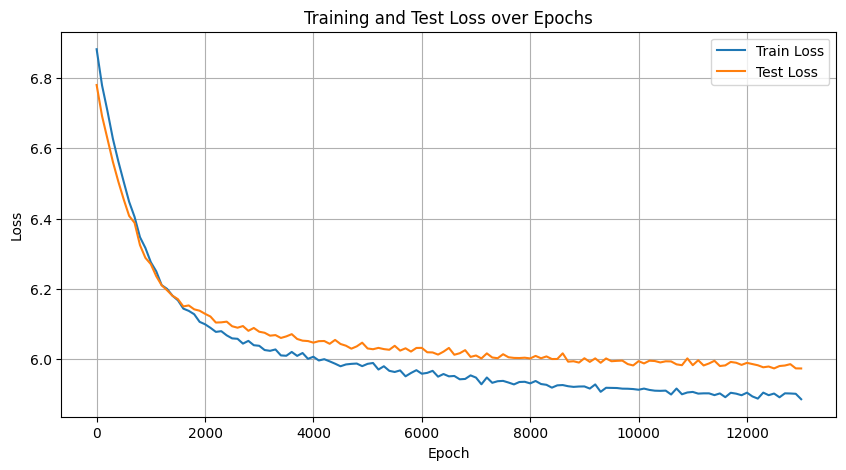

In [ ]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot([int(i*iters_per_tl) for i in range(len(train_losses))],train_losses, label='Train Loss')
plt.plot([int(i*iters_per_tl) for i in range(len(test_losses))],test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
# plt.ylim((0,max(train_losses+test_losses)))
plt.legend()
plt.grid(True)
plt.show()

LOAD `4f5a92` AT 6k and then evaluate.

In [ ]:
# import gc
# del model
# del batch
# del loss
# del optimizer
# gc.collect()
# torch.cuda.empty_cache()
# optimizer.zero_grad()
# torch.cuda.mem_get_info()

In [ ]:
import sys
sys.exit()